# Multiple Schemas

## Review

We just covered state schema as well as reducers.

Typically, all graph nodes communicate with a single schema that contains that graph input and output.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is not required in the overall graph input / output.

* We may also want to use different input / output schemas. 

Here, we'll discuss a few ways to tackle these!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the input or output.

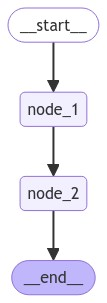

In [6]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

You can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we defin an internal or overall schema that contains all keys relevant to graph operations.

However, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

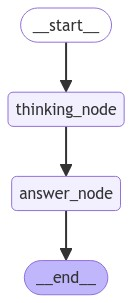

In [8]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke only includes the output schema.

In [9]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

Now, let's use the `input` - `output` schema.

We can see the `output` schema constains the output.

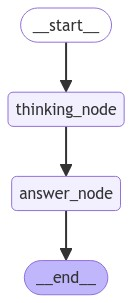

{'answer': 'bye Lance'}

In [11]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OutputState):
    return {"answer": "bye Lance"}

graph = StateGraph(input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})